# Image Classification between Butterflies and Bees

## Check working enviro and path 

In [1]:
# test
print("hello world")

hello world


In [2]:
import os
!pwd

os.chdir("/expanse/lustre/scratch/jenmar528/temp_project/")
!pwd
!ls

/home/jenmar528
/expanse/lustre/scratch/jenmar528/temp_project
all_imgs	   butterfly_data.zip		   newbeeimgs_renamed
bee_data	   butterfly_imgs		   testdir
bee_data.csv	   dataset_butterflies_bees	   testo
bee_data.zip	   dataset_dogs_vs_cats		   testo3_backup
bee_imgs	   ipykernel_launcher.py_plot.png  testo_backup
bee_wasp_data.zip  kaggle_bee_vs_wasp
butterfly_data	   new_bee_imgs_test


## Separate into Train and Testing data

In [3]:
# load dataset, reshape and save to a new file
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import random
import shutil

In [ ]:
# create directories
dataset_home = 'dataset_butterflies_bees/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['butterflies/', 'bees/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)

In [ ]:
# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'all_imgs/'
for file in os.listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random.random() < val_ratio:
		dst_dir = 'test/'
    # all butterfly files are named as butterfly_x with x being some integer number
	if file.startswith('butterfly'):
		dst = dataset_home + dst_dir + 'butterflies/'  + file
		shutil.copyfile(src, dst)
    # all bee files are named as bee_x with x being some integer number
	elif file.startswith('bee'):
		dst = dataset_home + dst_dir + 'bees/'  + file
		shutil.copyfile(src, dst)

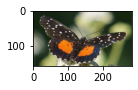

In [4]:
# plot test butterfly photo 
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder = 'dataset_butterflies_bees/train/butterflies/'

pyplot.subplot(330 + 1)
filename = folder + 'butterfly_4006.jpg'
image = imread(filename)
pyplot.imshow(image)

# show the figure
pyplot.show()

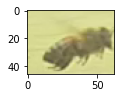

In [5]:
# plot test bee photo 
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder = 'dataset_butterflies_bees/train/bees/'

pyplot.subplot(330 + 1)
filename = folder + 'bee_3560.png'
image = imread(filename)
pyplot.imshow(image)

# show the figure
pyplot.show()

In [ ]:
# plot test new bee photo 
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder = 'newbeeimgs_renamed/'

pyplot.subplot(330 + 1)
filename = folder + 'bee_5000.png'
image = imread(filename)
pyplot.imshow(image)

# show the figure
pyplot.show()

## Develop a Baseline CNN Model


In [6]:
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [7]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [9]:
# if image is bugged, do not use it
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [10]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_butterflies_bees/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_butterflies_bees/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	print("got past test_it")
	# fit model
	history = model.fit(my_gen(train_it), steps_per_epoch=len(train_it),
		validation_data=my_gen(test_it), validation_steps=len(test_it), epochs=20, verbose=1)
	print("got past history")
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 

In [ ]:
# entry point, run the test harness
run_test_harness()

Found 7058 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
got past test_it
Epoch 1/20
100/111 [==========================>...] - ETA: 43s - loss: 0.3954 - accuracy: 0.8469

## Dropout Regularization


In [ ]:
# baseline model with dropout for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [ ]:
# if image is bugged, do not use it
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_butterflies_bees/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_butterflies_bees/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	print("got past test_it")
	# fit model
	history = model.fit(my_gen(train_it), steps_per_epoch=len(train_it),
		validation_data=my_gen(test_it), validation_steps=len(test_it), epochs=30, verbose=1)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [ ]:
# entry point, run the test harness
run_test_harness()

## Image Data Augmentation

In [ ]:
# baseline model with data augmentation for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_butterflies_bees/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_butterflies_bees/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 

In [ ]:
# entry point, run the test harness
run_test_harness()